# Creating a LangGraph Approach

Approach:

Step 1: System prompt to analyse taxonomy and identify topic for question and why
Step 2: Create a question for user
Step 3: Take user input
Step 4: Analyse user response using system promp
Step 5: Decision:
    Move on to next topic if answer is sufficient
    Continue asking about this topic if not -> step 1
    Max three iterations per top
Step 6: Move onto next topic
Step 7: Max 2 topics before ending intverview

In [1]:
# Define the interview domains and skills structure
INTERVIEW_DOMAINS = {
    "domains": [
        {
            "name": "LLM Architecture & Theory",
            "subdomains": [
                {
                    "name": "Model Architecture",
                    "core_skills": [
                        {
                            "name": "Transformer Architecture",
                            "knowledge_areas": [
                                "Attention Mechanisms",
                                "Tokenization Methods"
                            ],
                            "practical_applications": [
                                "Model Selection",
                                "Architecture Optimization",
                            ],
                        }
                    ]
                },
                {
                    "name": "Training Methods",
                    "core_skills": [
                        {
                            "name": "Fine-tuning Techniques",
                            "knowledge_areas": [
                                "LoRA",
                                "RLHF"
                            ],
                            "practical_applications": [
                                "Domain Adaptation",
                                "Model Customization"
                            ],
                        }
                    ]
                }
            ]
        },
        {
            "name": "LLM Development",
            "subdomains": [
                {
                    "name": "Prompt Engineering",
                    "core_skills": [
                        {
                            "name": "Advanced Prompting",
                            "knowledge_areas": [
                                "Chain-of-thought",
                                "Few-shot Learning",
                            ],
                            "practical_applications": [
                                "Prompt Template Creation",
                                "Response Optimization",
                            ]
                        }
                    ]
                }
            ]
        }
    ]
}

## Lets build

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated, Literal, List, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
import json
import random

Define Pydantic models to output structure

In [12]:
class TopicSelection(BaseModel):
    selected_topic: str = Field(description="The topic/domain selected for questioning")
    selected_subdomain: str = Field(description="The specific subdomain to focus on")
    selected_skill: str = Field(description="The specific skill to assess")
    reasoning: str = Field(description="Why this topic was selected for the current context")

class Question(BaseModel):
    question: str = Field(description="The interview question to ask")
    topic_focus: str = Field(description="What specific aspect this question is testing")
    difficulty_level: str = Field(description="Beginner, Intermediate, or Advanced")

class ResponseEvaluation(BaseModel):
    quality_score: float = Field(description="Score between 0-1 representing response quality")
    demonstrates_knowledge: bool = Field(description="Whether the response shows adequate knowledge")
    areas_of_strength: List[str] = Field(description="What the candidate did well")
    areas_for_improvement: List[str] = Field(description="Areas that could be better")
    should_continue_topic: bool = Field(description="Whether to ask another question on this topic")
    reasoning: str = Field(description="Detailed reasoning for the evaluation")


Define the interview state

In [13]:
class InterviewState(TypedDict):
    # Core interview data
    taxonomy: Dict[str, Any]
    messages: Annotated[List[BaseMessage], "Chat history"]
    
    # Topic tracking
    current_domain: str
    current_subdomain: str 
    current_skill: str
    topics_covered: List[Dict[str, str]]
    
    # Progress tracking
    questions_asked_current_topic: int
    total_questions_asked: int
    topics_completed: int
    
    # Evaluation data
    current_evaluation: Dict[str, Any]
    overall_performance: List[Dict[str, Any]]
    
    # Flow control
    should_continue_interview: bool
    interview_complete: bool

In [14]:
from langchain_openai import ChatOpenAI

# For normal accurate responses
llm = ChatOpenAI(temperature=0.05, model="gpt-4o-mini")

topic_selector_llm = llm.with_structured_output(TopicSelection)
question_generator_llm = llm.with_structured_output(Question)
evaluator_llm = llm.with_structured_output(ResponseEvaluation)

### Step 1: Analyse Taxonomy and select topic

In [15]:
def analyze_taxonomy_and_select_topic(state: InterviewState) -> InterviewState:
    """Step 1: Analyze taxonomy and identify topic for question"""
    
    # Create a prompt to analyze the taxonomy and select next topic
    system_prompt = """You are an expert technical interviewer. Analyze the provided skills taxonomy and conversation history to select the most appropriate topic for the next question.

    Consider:
    1. What topics have already been covered
    2. The candidate's demonstrated skill level so far
    3. Logical progression of topics
    4. Areas that need deeper exploration
    
    Select a domain, subdomain, and specific skill that would provide the most valuable assessment data."""
    
    # Format the taxonomy and history for the LLM
    taxonomy_str = json.dumps(state["taxonomy"], indent=2)
    topics_covered_str = json.dumps(state["topics_covered"], indent=2)
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"""
        Skills Taxonomy:
        {taxonomy_str}
        
        Topics Already Covered:
        {topics_covered_str}
        
        Total Questions Asked: {state['total_questions_asked']}
        Topics Completed: {state['topics_completed']}
        
        Select the next topic to explore.""")
    ]
    
    topic_selection = topic_selector_llm.invoke(messages)
    
    return {
        **state,
        "current_domain": topic_selection.selected_topic,
        "current_subdomain": topic_selection.selected_subdomain,
        "current_skill": topic_selection.selected_skill,
        "messages": state["messages"] + [
            AIMessage(content=f"[INTERNAL] Selected topic: {topic_selection.selected_topic} - {topic_selection.selected_subdomain} - {topic_selection.selected_skill}. Reasoning: {topic_selection.reasoning}")
        ]
    }

### Step 2: Create Question

In [16]:
def generate_question(state: InterviewState) -> InterviewState:
    """Step 2: Create a question for user"""
    
    system_prompt = """You are an expert technical interviewer. Generate a thoughtful, targeted question based on the selected topic and the candidate's conversation history.

    The question should:
    1. Test both theoretical knowledge and practical application
    2. Be appropriate for the candidate's demonstrated skill level
    3. Allow for meaningful follow-up
    4. Be clear and unambiguous
    5. Encourage detailed responses"""
    
    # Get recent conversation for context
    recent_messages = state["messages"][-6:] if len(state["messages"]) > 6 else state["messages"]
    conversation_context = "\n".join([
        f"{msg.__class__.__name__}: {msg.content}" for msg in recent_messages
        if not msg.content.startswith("[INTERNAL]")
    ])
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"""
        Current Topic Focus:
        - Domain: {state['current_domain']}
        - Subdomain: {state['current_subdomain']}
        - Skill: {state['current_skill']}
        
        Questions asked on this topic: {state['questions_asked_current_topic']}
        
        Recent conversation context:
        {conversation_context}
        
        Generate an appropriate interview question.""")
    ]
    
    question_obj = question_generator_llm.invoke(messages)
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=question_obj.question)],
        "questions_asked_current_topic": state["questions_asked_current_topic"] + 1,
        "total_questions_asked": state["total_questions_asked"] + 1
    }

### Await User Input

In [17]:
def wait_for_user_input(state: InterviewState) -> InterviewState:
    """Step 3: Wait for and capture user input - this is handled externally"""
    # In a real implementation, this would pause for user input
    # For demo purposes, we'll simulate or handle this in the invoke call
    return state

### Step 4: Analyse User Response

In [18]:
def analyze_response(state: InterviewState) -> InterviewState:
    """Step 4: Analyze user response using system prompt"""
    
    if not state["messages"] or not isinstance(state["messages"][-1], HumanMessage):
        return state
    
    user_response = state["messages"][-1].content
    
    system_prompt = f"""You are an expert technical interviewer evaluating a candidate's response. Analyze the response thoroughly and provide detailed feedback.

    Current Assessment Context:
    - Domain: {state['current_domain']}
    - Subdomain: {state['current_subdomain']}
    - Skill: {state['current_skill']}
    - Question Number on this topic: {state['questions_asked_current_topic']}
    
    Evaluate the response for:
    1. Technical accuracy and depth
    2. Practical understanding
    3. Communication clarity
    4. Areas of strength and improvement
    5. Whether additional questions on this topic would be valuable
    
    Provide a quality score between 0-1 and determine if we should continue with this topic or move on."""
    
    # Get the question that was asked
    ai_messages = [msg for msg in state["messages"] if isinstance(msg, AIMessage) and not msg.content.startswith("[INTERNAL]")]
    last_question = ai_messages[-1].content if ai_messages else "No previous question found"
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"""
        Question Asked: {last_question}
        
        Candidate's Response: {user_response}
        
        Please evaluate this response.""")
    ]
    
    evaluation = evaluator_llm.invoke(messages)
    
    # Store the evaluation
    evaluation_data = {
        "question": last_question,
        "response": user_response,
        "quality_score": evaluation.quality_score,
        "demonstrates_knowledge": evaluation.demonstrates_knowledge,
        "areas_of_strength": evaluation.areas_of_strength,
        "areas_for_improvement": evaluation.areas_for_improvement,
        "should_continue_topic": evaluation.should_continue_topic,
        "reasoning": evaluation.reasoning,
        "topic": f"{state['current_domain']} - {state['current_subdomain']} - {state['current_skill']}"
    }
    
    return {
        **state,
        "current_evaluation": evaluation_data,
        "overall_performance": state["overall_performance"] + [evaluation_data],
        "messages": state["messages"] + [
            AIMessage(content=f"[INTERNAL] Evaluation complete. Quality score: {evaluation.quality_score:.2f}. Should continue topic: {evaluation.should_continue_topic}")
        ]
    }

## Step 5: Decide Next Step

In [19]:
def decide_next_step(state: InterviewState) -> Literal["continue_topic", "next_topic", "end_interview"]:
    """Step 5: Decision logic for interview flow"""
    
    # Check if we should end the interview (max 2 topics)
    if state["topics_completed"] >= 2:
        return "end_interview"
    
    # Check if we've asked too many questions on current topic (max 3 iterations)
    if state["questions_asked_current_topic"] >= 3:
        return "next_topic"
    
    # Check evaluation results
    if state["current_evaluation"]:
        evaluation = state["current_evaluation"]
        
        # If quality is very low and we've asked multiple questions, move on
        if evaluation["quality_score"] < 0.3 and state["questions_asked_current_topic"] >= 2:
            return "next_topic"
        
        # If candidate demonstrates good knowledge, we can move on
        if evaluation["demonstrates_knowledge"] and evaluation["quality_score"] > 0.7:
            return "next_topic"
        
        # If evaluation suggests continuing with topic
        if evaluation["should_continue_topic"]:
            return "continue_topic"
    
    # Default to next topic if we've asked 2+ questions
    if state["questions_asked_current_topic"] >= 2:
        return "next_topic"
    
    return "continue_topic"

## Step 6: Move to the next topic

In [20]:
def move_to_next_topic(state: InterviewState) -> InterviewState:
    """Step 6: Move onto next topic"""
    
    # Record the completed topic
    completed_topic = {
        "domain": state["current_domain"],
        "subdomain": state["current_subdomain"],
        "skill": state["current_skill"],
        "questions_asked": state["questions_asked_current_topic"]
    }
    
    return {
        **state,
        "topics_covered": state["topics_covered"] + [completed_topic],
        "topics_completed": state["topics_completed"] + 1,
        "questions_asked_current_topic": 0,
        "current_domain": "",
        "current_subdomain": "",
        "current_skill": "",
        "messages": state["messages"] + [
            AIMessage(content=f"[INTERNAL] Moving to next topic. Topics completed: {state['topics_completed'] + 1}")
        ]
    }

### Step 7: End Interview

In [21]:
def end_interview(state: InterviewState) -> InterviewState:
    """Step 7: End interview and provide summary"""
    
    # Calculate overall performance
    total_score = sum([eval_data["quality_score"] for eval_data in state["overall_performance"]])
    avg_score = total_score / len(state["overall_performance"]) if state["overall_performance"] else 0
    
    summary = f"""
    Interview Complete!
    
    Summary:
    - Topics Covered: {len(state['topics_covered'])}
    - Total Questions Asked: {state['total_questions_asked']}
    - Average Performance Score: {avg_score:.2f}/1.0
    
    Performance by Topic:
    """
    
    for eval_data in state["overall_performance"]:
        summary += f"\n- {eval_data['topic']}: {eval_data['quality_score']:.2f}/1.0"
    
    return {
        **state,
        "interview_complete": True,
        "should_continue_interview": False,
        "messages": state["messages"] + [AIMessage(content=summary)]
    }

## Create Interactive Workflow

In [34]:
def create_interview_workflow():
    """Create and compile the interview workflow"""
    
    workflow = StateGraph(InterviewState)
    
    # Add nodes
    workflow.add_node("analyze_and_select", analyze_taxonomy_and_select_topic)
    workflow.add_node("generate_question", generate_question)
    workflow.add_node("analyze_response", analyze_response)
    workflow.add_node("next_topic", move_to_next_topic)
    workflow.add_node("end_interview", end_interview)
    
    # Define edges
    workflow.add_edge(START, "analyze_and_select")
    workflow.add_edge("analyze_and_select", "generate_question")
    
    # Add interrupt before analyze_response to wait for user input
    workflow.add_edge("generate_question", "analyze_response")
    
    # Conditional edges for decision making
    workflow.add_conditional_edges(
        "analyze_response",
        decide_next_step,
        {
            "continue_topic": "analyze_and_select",
            "next_topic": "next_topic", 
            "end_interview": "end_interview"
        }
    )
    
    workflow.add_edge("next_topic", "analyze_and_select")
    workflow.add_edge("end_interview", END)
    
    # Add memory for conversation persistence
    memory = MemorySaver()
    
    # Compile with interrupt before analyze_response
    return workflow.compile(checkpointer=memory, interrupt_before=["analyze_response"])

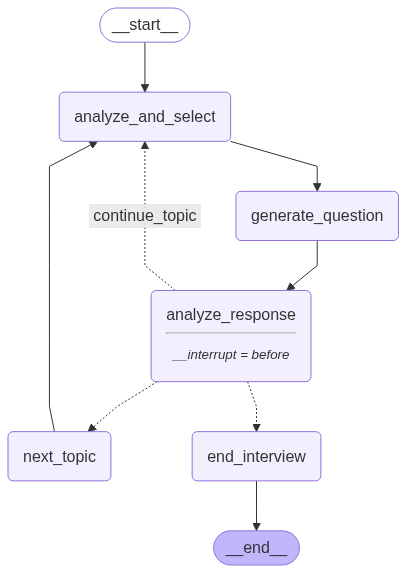

In [35]:
interview_app = create_interview_workflow()
interview_app

In [36]:
def start_interview(taxonomy: Dict[str, Any], thread_id: str = "interview_1"):
    """Start a new interview session"""
    
    initial_state = {
        "taxonomy": taxonomy,
        "messages": [SystemMessage(content="Starting technical interview session...")],
        "current_domain": "",
        "current_subdomain": "",
        "current_skill": "",
        "topics_covered": [],
        "questions_asked_current_topic": 0,
        "total_questions_asked": 0,
        "topics_completed": 0,
        "current_evaluation": {},
        "overall_performance": [],
        "should_continue_interview": True,
        "interview_complete": False
    }
    
    config = {"configurable": {"thread_id": thread_id}}
    
    # Run until we hit the interrupt (after generating first question)
    result = interview_app.invoke(initial_state, config)
    
    # Extract the actual question (not internal messages)
    questions = [msg.content for msg in result["messages"] 
                if isinstance(msg, AIMessage) and not msg.content.startswith("[INTERNAL]")]
    
    if questions:
        print("INTERVIEWER:", questions[-1])
    
    return result, config

def continue_interview(user_response: str, config: Dict[str, Any]):
    """Continue the interview with a user response"""
    
    # Get the current state
    current_state = interview_app.get_state(config)
    
    # Add user response to the conversation
    current_state.values["messages"].append(HumanMessage(content=user_response))
    
    # Update the state with the user's message
    interview_app.update_state(config, {"messages": current_state.values["messages"]})
    
    # Continue execution from where it was interrupted
    result = interview_app.invoke(None, config)
    
    # Check if interview is complete
    if result["interview_complete"]:
        print("INTERVIEW COMPLETE!")
        # Extract summary
        ai_messages = [msg.content for msg in result["messages"] 
                      if isinstance(msg, AIMessage) and not msg.content.startswith("[INTERNAL]")]
        if ai_messages:
            print(ai_messages[-1])
        return result
    
    # Extract the next question
    questions = [msg.content for msg in result["messages"] 
                if isinstance(msg, AIMessage) and not msg.content.startswith("[INTERNAL]")]
    
    if questions:
        print("INTERVIEWER:", questions[-1])
    
    return result

In [37]:
# Start the interview
state, config = start_interview(INTERVIEW_DOMAINS)

INTERVIEWER: Can you explain the key components of the Transformer architecture and how they contribute to its performance in natural language processing tasks? Additionally, could you provide an example of how you would implement a Transformer model for a specific application, such as text summarization or translation?


In [38]:
# Continue with user responses
state = continue_interview(
    """The Transformer architecture's key components are crucial for its NLP performance.

Self-Attention: Allows the model to weigh the importance of different words in a sequence relative to each other, capturing long-range dependencies effectively.
Positional Encoding: Adds information about the position of each word, as the self-attention mechanism processes words in parallel, losing inherent order.
Encoder-Decoder Structure: The encoder processes the input sequence, building rich representations, while the decoder uses these to generate the output sequence. Each consists of multiple identical layers.
Feed-Forward Networks: Provide non-linearity and further transform representations within each layer.
Residual Connections & Layer Normalisation: Aid training by enabling better gradient flow and stabilising activations.
For text summarisation, you'd typically use a pre-trained encoder-decoder Transformer model (e.g., BART or T5) from libraries like Hugging Face. You'd fine-tune it on a dataset of articles and their summaries. The encoder would process the input article, and the decoder would generate a concise summary based on the learned relationships and the input context.""", 
config
)

INTERVIEWER: Can you explain the concept of fine-tuning in the context of large language models, particularly focusing on the differences between task-specific fine-tuning and domain adaptation? Additionally, could you describe a practical scenario where you would choose one method over the other, and what considerations would influence your decision?


In [40]:
# Continue with user responses
state = continue_interview(
    """Fine-tuning adapts pre-trained LLMs. Task-specific fine-tuning optimises the model for a new, specific task (e.g., sentiment analysis). Domain adaptation adjusts the model to perform better on data from a different domain (e.g., legal text), retaining general capabilities. Choose task-specific for a precise new job, domain adaptation for better performance on new data within similar existing tasks.
Fine-tuning adapts a pre-trained LLM. Task-specific fine-tuning optimises the model for a specific task (e.g., sentiment analysis) with labelled data. Domain adaptation makes the model proficient in a new domain (e.g., legal or medical text) using unlabelled domain-specific data.

    Choose domain adaptation if your core issue is the LLM's understanding of domain-specific terminology. Choose task-specific fine-tuning if the LLM understands the domain but struggles with a particular job. Considerations include data availability and the required degree of specialisation.

    """, 
config
)

INTERVIEWER: Given your understanding of task-specific fine-tuning and domain adaptation, can you describe a scenario where you would implement advanced prompting techniques to enhance the performance of a large language model in a specific application? Please detail the types of prompts you would use, how you would evaluate their effectiveness, and any challenges you might face during this process.


In [41]:
# Continue with user responses
state = continue_interview(
    """For a complex, low-resource classification task, I'd use advanced prompting. Techniques like few-shot prompting (providing examples in the prompt), chain-of-thought prompting (guiding the LLM through reasoning steps), or self-consistency would be employed. Effectiveness would be evaluated via accuracy metrics on a validation set. Challenges include prompt engineering complexity and sensitivity to minor changes.
For enhancing an LLM in a new, niche domain like medical research article summarisation, I'd use advanced prompting.

Types of Prompts: I'd employ Chain-of-Thought prompts (e.g., "Think step-by-step to extract key findings, then summarise") and Few-shot prompting with examples of medical articles and their ideal summaries.

Evaluation: Assess effectiveness using ROUGE scores for summary quality and human expert review for factual accuracy and conciseness.

Challenges: Avoiding hallucination of medical facts and maintaining consistent summarisation style across diverse articles.
    """, 
config
)

INTERVIEW COMPLETE!

    Interview Complete!
    
    Summary:
    - Topics Covered: 2
    - Total Questions Asked: 3
    - Average Performance Score: 0.80/1.0
    
    Performance by Topic:
    
- LLM Architecture & Theory - Model Architecture - Transformer Architecture: 0.85/1.0
- LLM Architecture & Theory - Training Methods - Fine-tuning Techniques: 0.75/1.0
- LLM Development - Prompt Engineering - Advanced Prompting: 0.80/1.0
